In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

Parsing:

In [29]:
with open('/home/kirill/учёба/ML/my_homeworks/hw1/1.txt', 'r') as f:
    n_features = int(f.readline())
    n_objects = int(f.readline())
lines = np.loadtxt('/home/kirill/учёба/ML/my_homeworks/hw1/1.txt',max_rows=n_objects, skiprows=2, comments="#", unpack=False)

X = lines[:, 0:lines.shape[1]-1]
Y = lines[:, lines.shape[1]-1]

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

Out of the box realization

In [31]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
lr = LinearRegression()
lr.fit(x_train, y_train)
print(f'R2: {lr.score(x_test, y_test)}')

R2: 0.9999992940370418


Here's my Linear Regression algorithm using SGD or LS:  

In [21]:
@dataclass
class Linear_Regression(BaseEstimator, RegressorMixin):
    '''Linear Rergession with L2 regularization and SGD or LS optimizer
    '''
    C: float=1.0
    batch_size: int=60
    lr: float=1e-2
    num_steps: int=2000
    method: str='SGD'
    tau: float=1e-3
   

    def fit(self, X, Y):
        n_objects = len(X)
        n_features = X.shape[1]
        nrmse_history_list = []
        if self.method == 'SGD':
            w = np.random.randn(X.shape[1])
            for i in range(self.num_steps):
                sample_indices = np.random.randint(n_objects, size=self.batch_size)
                nrmse = 2 * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / self.batch_size
                w -= self.lr * ( nrmse + self.tau * w)
                nrmse_history_list.append(nrmse)
            
            self.nrmse_history_list = np.array(nrmse_history_list)   
            self.w = w
            return self
        
        elif self.method == 'LS':
            r = np.linalg.matrix_rank(X)
            U, sigma, VT = np.linalg.svd(X, full_matrices=False)
            D_plus = np.diag(np.hstack([1/(sigma[:r] ** 2 + self.tau), np.zeros(n_features-r)]))
            D = np.diag(np.hstack([sigma[:r], np.zeros(n_features-r)]))
            V = VT.T
            print(V.shape, D_plus.shape, D.shape, U.T.shape)
            X_plus = V.dot(D_plus).dot(D).dot(U.T)
            self.w = X_plus.dot(Y)
            return self

    def predict(self, X):
        return np.dot(X, self.w)

In [22]:
pipe_1 = make_pipeline(
    MinMaxScaler(),
    Linear_Regression()
)
pipe_2 = make_pipeline(
    MinMaxScaler(),
    Linear_Regression(method='LS'),
)

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$

In [23]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [24]:
pipe_1.fit(x_train, y_train)
print(f'R2: {pipe_1.score(x_test, y_test)}')

R2: 0.999999467436062


In [25]:
pipe_2.fit(x_train, y_train)
print(f'R2: {pipe_2.score(x_test, y_test)}')

(428, 428) (428, 428) (428, 428) (428, 873)
R2: 0.9999996029033921


In [26]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

MSE: 0.00013444440876172217
SMAPE: 0.027744063631564387


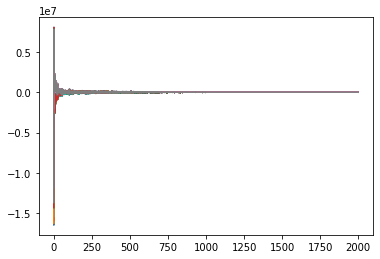

In [27]:
lin = Linear_Regression().fit(x_scaled, y_train)
y_pred = lin.predict(x_test_scaled)
NRMSE = mse(y_test, y_pred)**0.5/(max(y_pred) - min(y_pred))
SMAPE = smape(y_test, y_pred)
print(f'MSE: {NRMSE}')
print(f'SMAPE: {SMAPE}')
plt.plot(lin.nrmse_history_list);

In [12]:
lin = Linear_Regression("LS").fit(x_scaled, y_train)
y_pred = lin.predict(x_test_scaled)
NRMSE = mse(y_test, y_pred)**0.5/(max(y_pred) - min(y_pred))
SMAPE = smape(y_test, y_pred)
print(f'NRMSE: {NRMSE}')
print(f'SMAPE: {SMAPE}')

NRMSE: 0.00014970610646108687
SMAPE: 0.03038026660191274


In [34]:
score_history_list = np.zeros(200)
for t in [50, 100, 150, 199]:
    pipe = make_pipeline(MinMaxScaler(), Linear_Regression(tau = 1/(100*(t+1))))
    pipe.fit(x_train, y_train)
    score_history_list[t] = pipe.score(x_test, y_test)

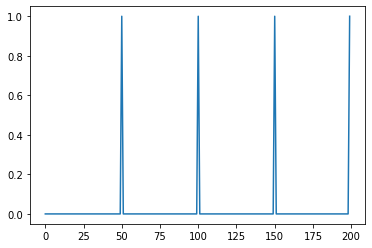

In [35]:
plt.plot(score_history_list)

In [36]:
max_score = max(score_history_list) 
idx = np.where(score_history_list == max_score)[0][0]
t = 1/((idx+1)*100)
print(f"tau = {t} \nmax score = {max_score}")

tau = 5e-05 
max score = 0.9999995181085043


In [37]:
pipe_1 = make_pipeline(
    MinMaxScaler(),
    Linear_Regression(tau=t)
)
pipe_1.fit(x_train, y_train)
print(f'R2: {pipe_1.score(x_test, y_test)}')

R2: 0.9999995156310676
